In [21]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import cv2
import extcolors
import skimage
import scipy
from PIL import Image
import math
import skimage
from sklearn.linear_model import LinearRegression
import pandas as pd
from colormap import rgb2hex
import numpy as np
import cv2
import os

import numpy as np
import cv2
import PerImageProcessing
import MaskingProcess
import Evaluation
import random


In [22]:

def hough_line_improved(mask, angle_acc):
    """
    input : 2D mask + list containing the angle previously found
    output : accumulator + array to convert theta and rhos to accumulator coordinates
    """
    # Rho and Theta ranges
    thetas = np.deg2rad(np.arange(0, 180))
    width, height = mask.shape
    diag_len = int(np.ceil(np.sqrt(width * width + height * height)))   # max_dist
    rhos = np.linspace(-diag_len, diag_len, num = diag_len * 2)

    # Cache some resuable values
    cos_t = np.cos(thetas)
    sin_t = np.sin(thetas)
    num_thetas = len(thetas)

    # Hough accumulator array of theta vs rho
    accumulator = np.zeros((2 * diag_len, num_thetas), dtype=np.uint64)
    acc_no_modif = np.zeros((2 * diag_len, num_thetas), dtype=np.uint64)
    y_idxs, x_idxs = np.nonzero(mask)  # (row, col) indexes to edges
    #print(y_idxs, x_idxs)

    # Vote in the hough accumulator
    for i in range(len(x_idxs)):
        #print('step ', i, 'of len ', len(x_idxs))
        x = x_idxs[i]
        y = y_idxs[i]

        for t_idx in range(num_thetas):
            # Calculate rho. diag_len is added for a positive index
            rho = round(x * cos_t[t_idx] + y * sin_t[t_idx]) + diag_len
            accumulator[rho, t_idx] += 1
            acc_no_modif[rho, t_idx] += 1
            if (abs(np.rad2deg(thetas[t_idx])-90)<25): #if horizontale lignes 
                accumulator[:, t_idx] = 0
            
            for angle in angle_acc:
                if (abs(np.rad2deg(thetas[t_idx])-np.rad2deg(angle))<10): #if angle already detected 
                    accumulator[:, t_idx] = 0


    return accumulator, thetas, rhos, acc_no_modif


In [54]:

def keep_mask_max_acc_lines(best_mask_edge, img_no_sky, crop_nb):
    """
    input : mask where we want to use HT, img to draw on it, 
            nb_of crops we want to detect
    output : new mask for next image, list of theta and r detected, 
            threshold_acc, best_mask_evaluate = img with lines drawned
    """

    best_mask_edge_copy = np.copy(best_mask_edge)
    best_mask_evaluate = np.copy(img_no_sky)
    img_no_sky_copy = np.copy(img_no_sky)
    band_width = int(img_no_sky.shape[1]/25)

    th_acc = []
    r_acc = []
    threshold_acc = []
    mask = []
    pts1 = []
    pts2 = []
    acc_acc = []
    acc_acc_no_modif = []

    for i in range(crop_nb):
        mask_single_crop = np.zeros_like(best_mask_edge)

        print('step ', (i+1), 'of ', crop_nb)
        acc, thetas, rhos, acc_no_modif = hough_line_improved(best_mask_edge_copy, th_acc)
        acc_acc_no_modif.append(acc_no_modif)

        th_max = acc.max()

        r_idx, th_idx = np.where(acc>=th_max)
        r = rhos[r_idx[0]]#in case multiple same max 
        th = thetas[th_idx[0]]

        th_acc.append(th)
        r_acc.append(r)
        threshold_acc.append(th_max)

        a = math.cos(th)
        b = math.sin(th)
        x0 = a * r
        y0 = b * r
        p1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pts1.append(p1)
        p2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        pts2.append(p2)
        

        cv2.line(best_mask_edge_copy, p1, p2, (0,0,0), band_width+10)
        if (i==0):
                plt.title('best_mask_edge_copy')
                plt.imshow(best_mask_edge_copy)

        cv2.line(best_mask_evaluate, p1, p2, (255,0,0), 3) 
        cv2.line(img_no_sky_copy, p1, p2, (255,0,0), 3)
        cv2.line(mask_single_crop, p1, p2, (255,0,0), band_width)
        mask.append(mask_single_crop)
        acc_acc.append(acc)
           

    return mask, th_acc, r_acc, threshold_acc, best_mask_evaluate, pts1, pts2, acc_acc, acc_acc_no_modif


In [55]:
import numpy as np
import cv2
import PerImageProcessing
import MaskingProcess
import Evaluation
import random

def Initial_Process(img, nb_row = 4, sky = 0):

    #Cut off sky
    if(sky==1) : 
        grad_sky = MaskingProcess.get_sky_region_gradient(img)
        img_no_sky = MaskingProcess.cut_image_from_mask(grad_sky, img)
    else : 
        img_no_sky = img

    best_mask_median, best_mask_brut, col_best_mask = MaskingProcess.veg_segmentation(img, img_no_sky)
    best_mask_median_edge = cv2.Canny(best_mask_median,100,200)
    best_mask_brut_edge = cv2.Canny(best_mask_brut,100,200)


    arr_mask, th_acc, r_acc, threshold_acc, best_mask_evaluate, pts1, pts2, acc_acc, acc_acc_no_modif = keep_mask_max_acc_lines(best_mask_brut_edge, img_no_sky, nb_row)

    vp_pt = np.asarray(MaskingProcess.VP_detection(th_acc, r_acc, threshold_acc, stage=0))

    return best_mask_evaluate, arr_mask, col_best_mask, vp_pt, acc_acc, acc_acc_no_modif

image read :  /home/roxane/Desktop/M3_2022/Caterra/dataset_straigt_lines/crop_row_211.JPG
the best color is : rgb  [ 95 131  70] hex :  #5F8346
step  1 of  5
step  2 of  5
step  3 of  5
step  4 of  5
step  5 of  5
check outliers
eps and var res :  1.5564177582651268 96.06344568770137
VP :  176 -56


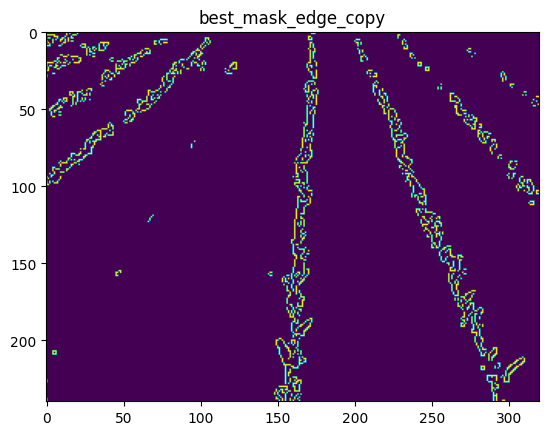

In [56]:
VID = 0
SING_IMG = 1
INI_PROCESS = 0
SPEED_PROCESS = 1
FINAL_PROCESS = 2



mode = SING_IMG
imgs_folder = '/home/roxane/Desktop/M3_2022/Caterra/dataset_straigt_lines'
name_images = 'crop_row_211.JPG' #crop_row_001, crop_row_020, crop_row_053
sky_on = 0
nb_row = 5
vp_on = 1

#open and resize images for consistency --> returns img in rgb format
images = MaskingProcess.obtain_images(name_images,imgs_folder, mode)

imgs_annotated = []
imgs_crops_only = []
stage = INI_PROCESS
vp_pt = 0
img = images[0]
hough_img, arr_mask, col_best_mask, vp_pt, acc_acc,acc_acc_no_modif = Initial_Process(img, nb_row = nb_row, sky = sky_on)
#plt.imshow(hough_img)

    

        

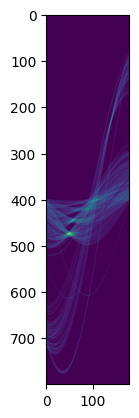

In [47]:
plt.imshow(acc_acc_no_modif[3])

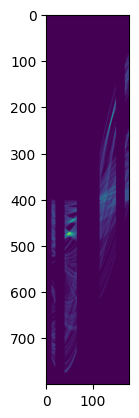

In [32]:
plt.imshow(acc_acc[3])

In [1]:
a= 0
b = None
print(a,b)

0 None


In [2]:
if(a==None):
    print(1)